# A Customer Segmentation using Self-Organizing Maps

## Setup

In [1]:
# uncomment this if you need to install these packages
# install.packages("purrr",verbose=TRUE)
# install.packages("popsom", verbose=TRUE)
# install.packages("ggplot2", verbose=TRUE)
# install.packages("hash", verbose=TRUE)

In [2]:
# need this later
library(purrr)

In [3]:
#library(popsom)
source("R/map-utils.R")
dyn.load("vsom.so")

Loading required package: fields
Loading required package: spam
Loading required package: dotCall64
Loading required package: grid
Spam version 2.5-1 (2019-12-12) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 
Loading required package: ggplot2
Loading required package: hash
hash-2.2.6.1 provided by Decision Patterns



## Data

The data we use is the `Mall Customers` data set by Vijay Choudhary available on [Kaggle](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python).

In [4]:
df <- read.csv("Mall_Customers.csv")
head(df)

,ID,Gender,Age,Income,Score
,<int>,<fct>,<int>,<int>,<int>
1,1,Male,19,15,39
2,2,Male,21,15,81
3,3,Female,20,16,6
4,4,Female,23,16,77
5,5,Female,31,17,40
6,6,Female,22,17,76


### Exploratory Data Analysis

In [5]:
summary(df)

       ID            Gender         Age            Income           Score      
 Min.   :  1.00   Female:112   Min.   :18.00   Min.   : 15.00   Min.   : 1.00  
 1st Qu.: 50.75   Male  : 88   1st Qu.:28.75   1st Qu.: 41.50   1st Qu.:34.75  
 Median :100.50                Median :36.00   Median : 61.50   Median :50.00  
 Mean   :100.50                Mean   :38.85   Mean   : 60.56   Mean   :50.20  
 3rd Qu.:150.25                3rd Qu.:49.00   3rd Qu.: 78.00   3rd Qu.:73.00  
 Max.   :200.00                Max.   :70.00   Max.   :137.00   Max.   :99.00  

In [6]:
# separate training data from labels
data <- subset(df,select= -c(ID,Gender))
labels <- subset(df,select= Gender)

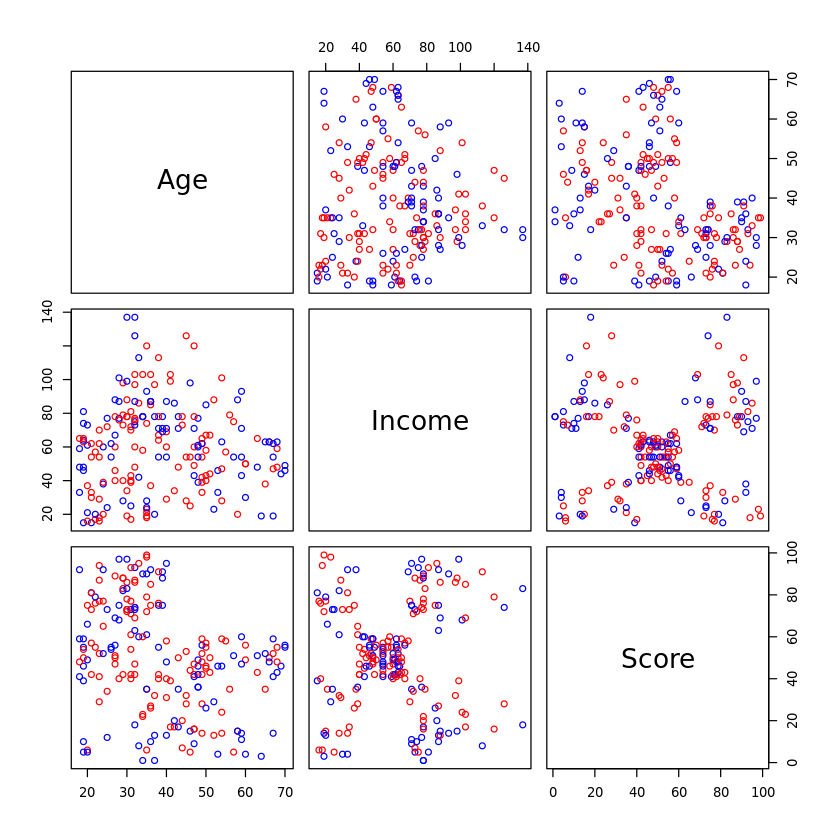

In [7]:
colors <- c("Red", "Blue")  
gender.colors <- sapply(as.character(df$Gender), function (x) {if (x == "Female") colors[1] else colors[2]})
pairs(data,col=gender.colors )

### Comments

**Overall observation**: No clear distinction between male and female shopping behavior.

**Age vs Income**: Both male and female high-earners are in their 30's and 40's.

**Age vs Score**: Adults under 40, both male and female, have the highest shopping scores.

**Income vs Score**: It is striking that here we can identify 5 strong clusters with several outlier clusters. The strongest cluster, dominated by females, is the cluster of an income in the range [\\$40k, \\$70k] and a score in the range of [40,60].

## Modeling

We will build a self-organzing map model for customer segmentation.  The package POPSOM not only constructs a self-organizing map model but also induces a centroid-based clustering model using the map.

### Self-Organizing Map Model

In [8]:
# build a map
# Note: we don't normalize because we want to be able to interpret the values at the centroids
m <- map(data,labels,xdim=15,ydim=10,train=100000,normalize=FALSE,seed=42)

In [9]:
# look at quality measures
cat("good map fit if convergence=",format(round(m$convergence,2),nsmall=2)," approx. 1\n",sep="")
cat("good cluster fit if (1-wcss/bcss)=",format(round(1-m$wcss/m$bcss,2),nsmall=2)," approx. 1\n",sep="")

good map fit if convergence=0.98 approx. 1
good cluster fit if (1-wcss/bcss)=0.90 approx. 1


**Observations**: We have a map convergence of 0.98 that means the neurons of the map capture virtually all of the variance of the training data and also preserve topographic neighbor relationships.  The underlying cluster model is also fitted well because the value of `(1-wcss/bcss)` with 0.90 is close to 1.

In [10]:
# number of clusters found
cat("number of clusters:",length(m$unique.centroids),"\n")

number of clusters: 6 


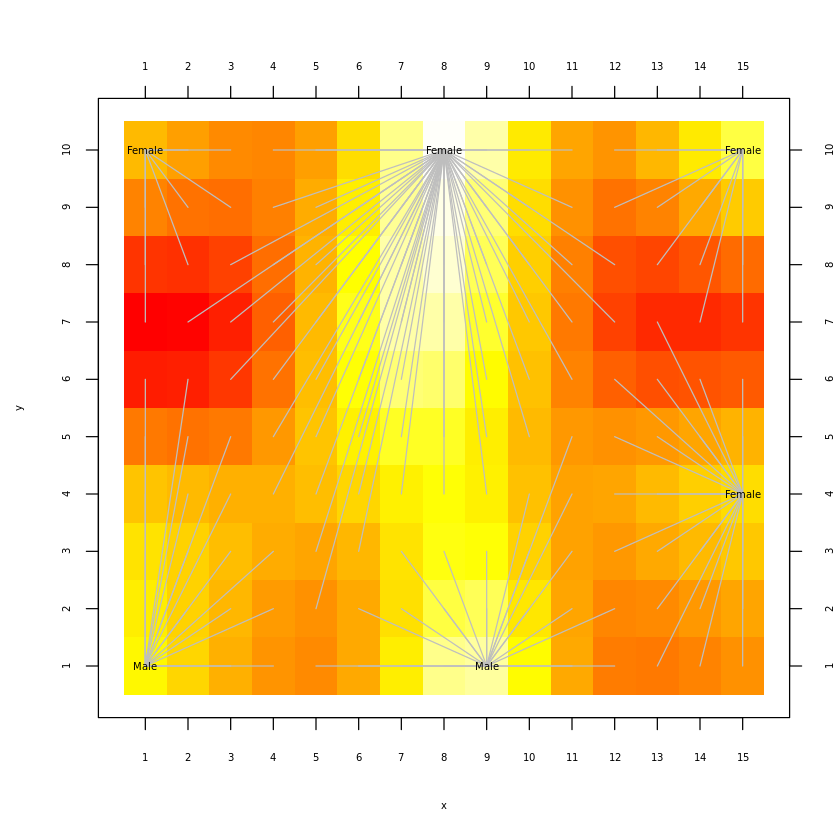

In [11]:
# visualization of the map together with the clusters and the corresponding centroids.
starburst(m)

**Observations**: Here we see a strong central cluster consisting of both male and female customers.  This central cluster is surrounded by less pronounced clusters.  This recalls the structure that we saw in our EDA.

**Note**: In self-organizing map visualizations the lighter the color the tighter the cluster. Dark orange to red indicates large physical distances between points.

### Detailed Analysis of the Model

In [12]:
# useful function for translating map coordinates into neuron indices
centroid.ix <- function (map,x,y) {x+(y-1)*map$xdim}

In [13]:
# construct a data frame of centroids
compute.centroids <- function (m)
{
    # construct first row of centroid table
    v <- list()
    # grab map location of first centroid
    x <- m$unique.centroids[[1]]$x
    y <- m$unique.centroids[[1]]$y
    # add the location to the table
    v <- append(v,x)
    v <- append(v,y)
    # get the neuron weight values of first centroid
    v <- append(v,round(as.numeric(m$neurons[centroid.ix(m,x,y),])))
    # get the number of observations in first cluster
    v <- append(v,length(m$centroid.obs[[1]]))
    # get majority label of cluster
    v <- append(v,m$centroid.labels[[x,y]])
    # turn vector into a row in the centroids table
    centroids <- as.vector(t(v))
    
    for (i in 2:length(m$unique.centroids))
    {
        v <- list()
        # grab map location of centroid i
        x <- m$unique.centroids[[i]]$x
        y <- m$unique.centroids[[i]]$y
        # add location to the table
        v <- append(v,x)
        v <- append(v,y)
        # get the neuron weight values of centroid i
        v <- append(v,round(as.numeric(m$neurons[centroid.ix(m,x,y),])))
        # get the number of observations in cluster i
        v <- append(v,length(m$centroid.obs[[i]]))
        # get majority label of cluster i
        v <- append(v,m$centroid.labels[[x,y]])
        # turn vector into a row in the centroids table
        centroids <- rbind(centroids,as.vector(t(v)))
    }
    centroids <- data.frame(centroids)
    names(centroids) <- c("x","y","Age","Income","Score","Size","Label")
    centroids
}

In [14]:
# list the centroids
centroids <- compute.centroids(m)
print(centroids)

   x  y Age Income Score Size  Label
1  1  1  39    110    22   29   Male
2  1 10  40     21    10   11 Female
3  8 10  66     56    50   73 Female
4  9  1  22     60    52   27   Male
5 15  4  32     85    91   37 Female
6 15 10  24     19    76   23 Female


**Observations**: As observed in our EDA we find a large, predominately female cluster at x=8 and y=10 on the map. The average income in this cluster is \\$56k and the score is 50.  What is surprising is that the average age in this cluster is 66.  We find another cluster close by at x=9 and y=1 with an average income of \\$60k and a score of 52.  However, this cluster is predominately male with an average age of 22.  Both of these clusters have similar income and score however they drastically differ in age, the males being much younger.  

Another striking observation is that high-income shoppers in their 30's differ in their shopping habits. Males have a much lower shopping score than females.  See clusters 1 and 4.

Finally, older, low-income females tend to be much more careful shoppers than younger, low-income females.  See clusters 2 and 6.

### Compare Model Centroids to Training Data

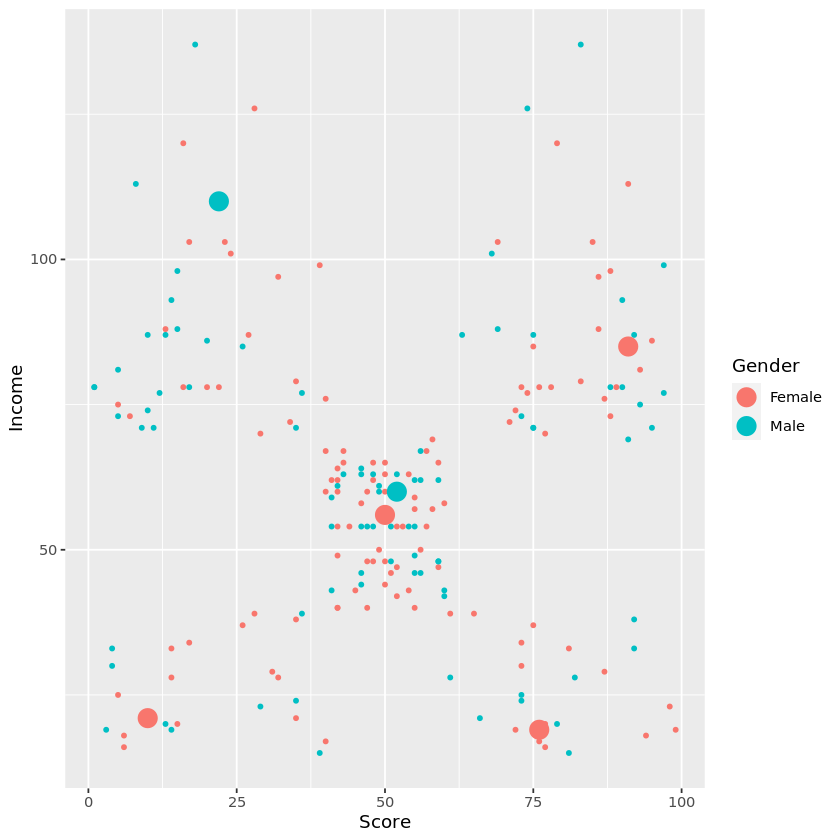

In [15]:
# let's see where those centroids fall: score vs income
centroids.coords <- data.frame(cbind(centroids$Score,centroids$Income,centroids$Label))
names(centroids.coords) <- c("Score","Income","Gender")
centroids.coords <- transform(centroids.coords,
                              Score=as.integer(Score),
                              Income=as.integer(Income),
                              Gender=as.character(Gender))
ggplot(df,aes(x=Score,y=Income,color=Gender)) + 
    geom_point(size=1) +
    geom_point(data=centroids.coords,size=5)

**Observation**: not unexpectedly the model centroids capture the clusters that we identified in our EDA.

### Variable Significance

Display relative significance of variables for clustering.

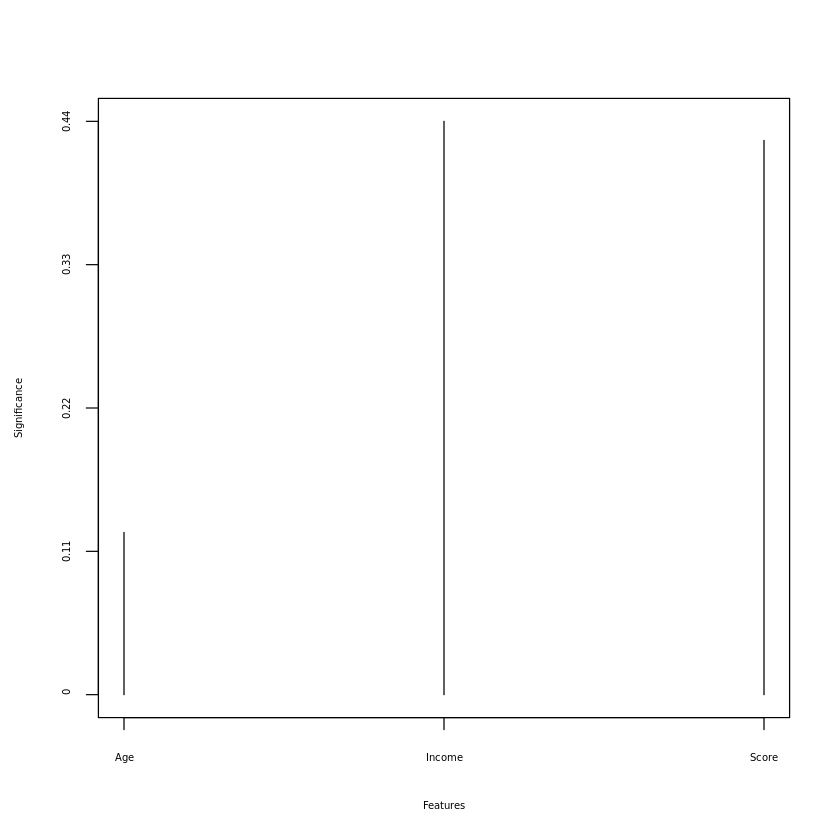

In [16]:
# which variables are the most significant?
significance(m)

**Observation**: as probably expected both Income and Score are highly predictive.

### Number of Centroids

Finally, let's double check if the number of clusters found by our model is reasonable.  We will use the [Elbow Method](https://uc-r.github.io/kmeans_clustering) which uses the k-means clustering algorithm to see how many clusters we should expect.  In the elbow method the number of clusters expected in a data set is indicated by the knee/elbow in the curve.

In [17]:
# code borrowed from https://uc-r.github.io/kmeans_clustering
elbow <- function (df)
{
    set.seed(123)

    # function to compute total within-cluster sum of square 
    wss <- function(k) {
      kmeans(df, k, nstart = 10 )$tot.withinss
    }

    # Compute and plot wss for k = 2 to k = 15
    k.values <- 2:15

    # extract wss for 2-15 clusters
    wss_values <- map_dbl(k.values, wss)

    plot(k.values, wss_values,
           type="b", pch = 19, frame = FALSE, 
           xlab="Number of clusters K",
           ylab="Total within-clusters sum of squares")
}

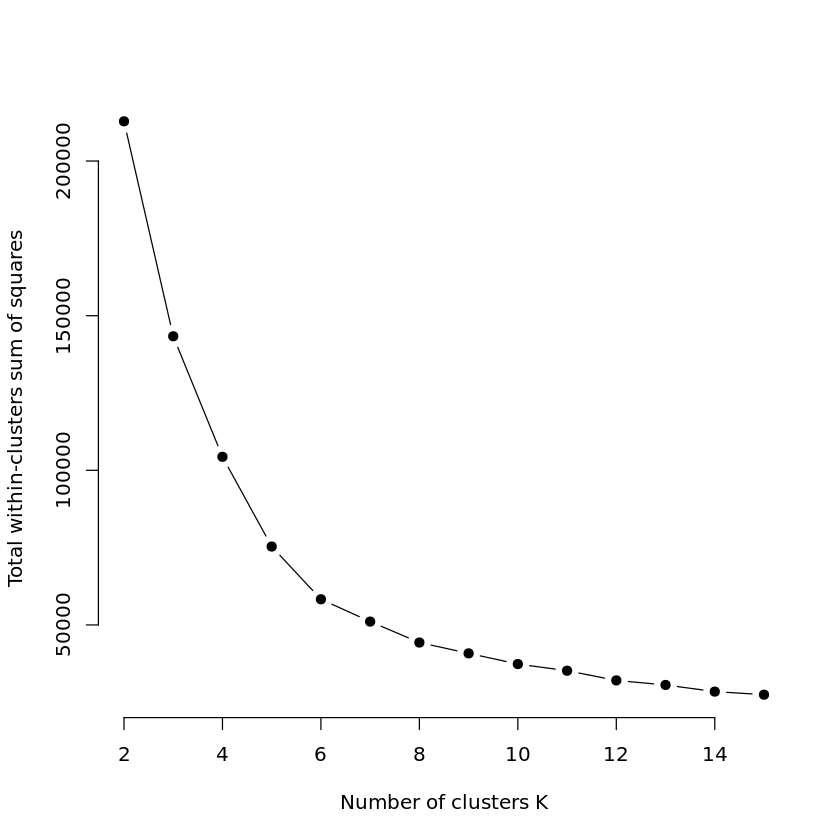

In [18]:
elbow(data)

**Observation**: Our self-organizing map model with 6 clusters sits right at the middle of the elbow.  So our model is reasonable.